In [1]:
import pandas as pd
from itertools import cycle
import gpflow
import numpy as np
from gpflow.utilities import print_summary, positive
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow import set_trainable
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import namedtuple
import statsmodels.api as sm

sns.set(style="white")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_summary_fmt("notebook")

/Users/leo/.pyenv/versions/3.8.7/envs/covid/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
<ipython-input-1-c9d6d75d7f0f>:21: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# Dataset

## Mobility

In [2]:
mobility_data = pd.read_csv(
    "./Data/Google/Global_Mobility_Report.csv", 
    encoding="ISO-8859-1", 
    parse_dates=["date"],
    dayfirst=True
)
mobility_data_us = mobility_data[
    (mobility_data["country_region"]=="United States") & 
    (~mobility_data["sub_region_1"].isnull()) &
    (mobility_data["sub_region_2"].isnull())
]
mobility_data_us_temp = mobility_data_us.iloc[:,7:] # keep only relevant columns
mobility_data_us_temp["state"] = mobility_data_us["sub_region_1"]
mobility_data_us_temp.iloc[:,1:-1] = mobility_data_us_temp.iloc[:,1:-1].apply(lambda x: x/100 + 1)
mobility_data_us =  mobility_data_us_temp.reset_index(drop=True)
mobility_data_us = pd.DataFrame({
    "state": mobility_data_us["state"],
    "date": mobility_data_us["date"],
    "HOME": mobility_data_us['residential_percent_change_from_baseline'],
    "WORK": mobility_data_us['workplaces_percent_change_from_baseline'],
    "RECREATIONAL": mobility_data_us['retail_and_recreation_percent_change_from_baseline'],
    "OTHER": mobility_data_us.iloc[:,2:5].mean(axis=1)
})

processed_dfs = []

for state in mobility_data_us["state"].unique():
    d = mobility_data_us[mobility_data_us["state"] == state].copy()
    
    d["HOME"] = d["HOME"].rolling(7).median()
    d["WORK"] = d["WORK"].rolling(7).median()
    d["RECREATIONAL"] = d["RECREATIONAL"].rolling(7).median()
    d["OTHER"] = d["OTHER"].rolling(7).median()

    processed_dfs.append(d)
    
mobility_data_us = pd.concat(processed_dfs)

/Users/leo/.pyenv/versions/3.8.7/envs/covid/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Cases

In [3]:
# COVID Cases from Microsoft, includes Recovered and Infected
ms_covid = pd.read_csv(
    "./Data/Microsoft/COVID_CASES.csv", 
    encoding="ISO-8859-1",
    parse_dates=["Updated"],
    dayfirst=False
)
ms_us_covid = ms_covid[
    (ms_covid["Country_Region"]=="United States") & 
    (~ms_covid["AdminRegion1"].isnull()) &
    (ms_covid["AdminRegion2"].isnull())
]
ms_us_covid = ms_us_covid.loc[:,["AdminRegion1", "Updated", "Confirmed", "ConfirmedChange", "Deaths", "Recovered"]]
ms_us_covid.rename(columns={"AdminRegion1": "state"}, inplace=True)
ms_us_covid.reset_index(drop=True, inplace=True)
population = pd.read_excel(
    "./Data/Population/US_population_raw_data.xls",
)
STATE_POPULATION = dict(zip(population[1:].Location, population[1:].COVIDTotal))

processed_dfs = []

for state in ms_us_covid["state"].unique():
    d = ms_us_covid[ms_us_covid["state"] == state]
    d = d.fillna(method='ffill').fillna(0)
    d["I"] = d["Confirmed"] - d["Deaths"] - d["Recovered"]

    d["S"] = int(STATE_POPULATION[state]) - d["I"]

    d["ConfirmedChange"] = np.log(d["ConfirmedChange"].rolling(7).median()+1)
    d["I"] = np.log(d["I"].rolling(7).median()+1)
    d["S"] = np.log(d["S"].rolling(7).median()+1)

    d.dropna(inplace=True)
    processed_dfs.append(d)
    
ms_us_covid = pd.concat(processed_dfs)
ms_us_covid["WEEKDAY"] = (ms_us_covid["Updated"].dt.dayofweek < 5).astype(int)
ms_us_covid["index"] = ms_us_covid["Updated"].dt.dayofyear

## Merge

In [4]:
final_data = ms_us_covid.merge(
    mobility_data_us, how='left', left_on=["state", "Updated"], right_on=["state", "date"]
)
final_data.dropna(inplace=True)
final_data.set_index("state", inplace=True)

# Model

In [ ]:
from model import COVIDGPModel

In [ ]:
def run_for_state(name, data):
    data = data.copy()
    data.reset_index(inplace=True, drop=True)
    t = data[["Updated"]]
    y = data[["ConfirmedChange"]]
    X = pd.DataFrame({
        "index": data["index"],
        "S": data["S"],
        "I": data["I"],
        "HOME": data["HOME"],
        "WORK": data["WORK"],
        "RECREATIONAL": data["RECREATIONAL"],
    }, index=data.index)[[
        "index",
        "S",
        "I",
        "HOME", 
        "WORK", 
        "RECREATIONAL"
    ]]

    model_params = {
        'kernel': (
            gpflow.kernels.SquaredExponential(lengthscales=np.ones(X.shape[1])) +
            gpflow.kernels.Linear() +
            gpflow.kernels.RationalQuadratic(lengthscales=np.ones(X.shape[1]))
        )
    }

    y_scaler = preprocessing.StandardScaler().fit(y)
    y_train = y_scaler.transform(y)

    x_scaler = preprocessing.StandardScaler().fit(X)
    X_train = x_scaler.transform(X)

    model = COVIDGPModel(name, **model_params)
    model.train(X_train, y_train)

    mean_train, var_train = model.predict(X_train)
    y_train_pred = y_scaler.inverse_transform(mean_train.numpy())
    y_train_true = y_scaler.inverse_transform(y_train)

    res = y_train_true - y_train_pred
    
    return model, res

In [ ]:
results_states = {}
for state in final_data.index.unique():
    data = final_data.loc[state]
    results_states[state] = run_for_state(state, data)

In [ ]:
import dill as pickle
pickle.dump(results_states, open('tmp/trained_models_states.pkl', 'wb'))

In [5]:
import dill as pickle
results_states = pickle.load(open('tmp/trained_models_states.pkl', 'rb'))

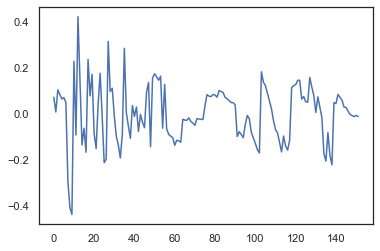

In [359]:
plt.plot([v[1] for v in results_states.values()][10])

## White noise

In [6]:
np.random.seed(123)
dates = pd.date_range(final_data[["Updated"]].min().values[0], final_data[["Updated"]].max().values[0]).values
u0 = np.random.normal(size=len(dates))

u0 = pd.DataFrame({"Updated": dates, "Residual": u0})
u0.head()

,Updated,Residual
0,2020-02-21,-1.085631
1,2020-02-22,0.997345
2,2020-02-23,0.282978
3,2020-02-24,-1.506295
4,2020-02-25,-0.578600


<AxesSubplot:>

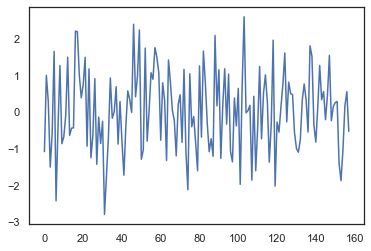

In [7]:
u0["Residual"].plot()

## $h_.(t)$ linear filters

In [8]:
from functools import partial

In [491]:
linear_filters_states = {}

ORDER = 5

for state in results_states.keys():
    u0_ = u0[u0['Updated'].isin(final_data.loc[state, 'Updated'])]
    state_residual = results_states[state][1]
    t = u0_["Updated"].index.astype('float').values.reshape(-1, 1)

    def _yule_walker(u=None, coeff_=None, sigma_=None):
        return np.convolve(coeff_, u, mode="same")

    rho_, sigma_ = sm.regression.yule_walker(state_residual, order=ORDER, method="mle")
    rho_ = np.array(rho_)[::-1]
    linear_filters_states[state] = rho_, partial(
        _yule_walker, u=u0_["Residual"].values, coeff_=tuple(rho_), sigma_=sigma_
    )
        

pickle.dump(linear_filters_states, open('tmp/linear_filters_states.pkl', 'wb'))

In [492]:
linear_filters_states = pickle.load(open('tmp/linear_filters_states.pkl', 'rb'))

In [493]:
times = None
for s in final_data.index.unique():
    s_times = set(final_data.loc[s, 'Updated'].unique())
    if times is None:
        times = s_times
    else:
        times = times.intersection(s_times)

In [557]:
u0_ = u0[u0['Updated'].isin(times)]['Residual'].values
T = u0_.shape[0]
t = np.arange(1, T + 1).reshape(-1, 1)

T2 = T - ORDER + 1

rhos = np.zeros((T2*N, T2*N))
for i, (hX, epsX) in enumerate(linear_filters_states.values()):
    for j, (hY, epsY) in enumerate(linear_filters_states.values()):
        hYi = hY[::-1]  
        for s in range(hYi.shape[0]):
            hYis = hYi[s:]
            rho = np.convolve(hX, hYis, mode="valid")
            rhos[(i+1)*T2-rho.shape[0]:(i+1)*T2, (j+1)*T2-s-1] = rho

In [565]:
rhos[140:148,144:148]

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.02714221,  0.        ,  0.        ,  0.        ],
       [-0.01671714,  0.05469098,  0.        ,  0.        ],
       [ 0.03318104, -0.0398453 ,  0.07410788,  0.        ],
       [ 0.00707625, -0.05920518,  0.03771614,  0.38392972]])

In [541]:
rhos.shape

(2516, 2516)

## Gram Matrix

In [566]:
def prepare_data_for_state(data):
    data = data.copy()
    data.reset_index(inplace=True)
    t = data[["Updated"]]
    y = data[["Updated", "ConfirmedChange"]]
    X = pd.DataFrame({
        "Updated": data["Updated"],
        "state": data["state"].apply(lambda v: list(results_states.keys()).index(v)),
        "index": data["index"],
        "S": data["S"],
        "I": data["I"],
        "HOME": data["HOME"],
        "WORK": data["WORK"],
        "RECREATIONAL": data["RECREATIONAL"],
    }, index=data.index)[[
        "Updated",
        "state",
        "index",
        "S",
        "I",
        "HOME", 
        "WORK", 
        "RECREATIONAL"
    ]]
    return X, y

In [567]:
ks = np.zeros((T2*N, T2))

final_data_ = final_data[final_data['Updated'].isin(times)]

for i, (s, (m, _r)) in enumerate(results_states.items()):
    data = final_data_.loc[s]
    X, _y = prepare_data_for_state(data)
    ks[i*T2:(i+1)*T2] = m.kernel((X.drop(columns=["Updated", "index"]).values[ORDER-1:]))
    

ks = np.repeat(ks, N, axis=1)

In [568]:
M = ks + rhos

In [569]:
M.shape

(2516, 2516)

In [570]:
np.linalg.matrix_rank(M)

163

In [571]:
np.linalg.det(M)

0.0

In [572]:
e_val, e_vec = np.linalg.eig(M)
np.max(e_val) / np.min(e_val)

(-202.1455960043138-0j)

In [573]:
M_reshaped = np.zeros((T2, N, T2, N))

for i in range(N):
    for j in range(N):
        v = M[i*T2:(i+1)*T2, j*T2:(j+1)*T2]
        M_reshaped[:, i, :, j] = v

In [574]:
M_reshaped.shape

(148, 17, 148, 17)

# GPFlow

In [164]:
final_data.index.unique()

Index(['Alaska', 'Alabama', 'Arkansas', 'Arizona', 'California', 'Colorado',
       'Connecticut', 'District of Columbia', 'Delaware', 'Florida', 'Georgia',
       'Hawaii', 'Iowa', 'Idaho', 'Illinois', 'Indiana', 'Kansas'],
      dtype='object', name='state')

In [281]:
multi_X, multi_y = None, None

final_data_ = final_data[final_data['Updated'].isin(list(sorted(times))[ORDER-1:])]

for s in results_states.keys():
    data = final_data_.loc[s]
    X, y = prepare_data_for_state(data)
    
    if multi_X is None:
        multi_X, multi_y = X, y
        prev_suffix = f"_{s}"
    else:
        suffixes, prev_suffix = (prev_suffix, f"_{s}"), ""
        multi_X = pd.merge(multi_X, X, left_on="Updated", right_on="Updated", suffixes=suffixes)
        multi_y = pd.merge(multi_y, y, left_on="Updated", right_on="Updated", suffixes=suffixes)
    
multi_X = multi_X.dropna().drop(columns=["Updated"])
multi_y = multi_y.dropna().drop(columns=["Updated"])

In [282]:
multi_X.shape, multi_y.shape

((148, 119), (148, 17))

In [283]:
multi_X_vals = multi_X.values
multi_y_vals = multi_y.values

In [320]:
class ManualConvolutionMultiOutput(gpflow.kernels.multioutput.kernels.MultioutputKernel):
    def __init__(self, results_states, gram_matrix):
        super().__init__()
        self.results_states = results_states
        self.gram_matrix = tf.convert_to_tensor(gram_matrix, dtype=tf.float64)
    
    @property
    def num_latent_gps(self):
        """The number of latent GPs in the multioutput kernel"""
        return 17

    @property
    def latent_kernels(self):
        """The underlying kernels in the multioutput kernel"""
        return tuple(v[0].kernel for v in self.results_states.values())
    
    def __call__(self, X, X2=None, *, full_cov=False, full_output_cov=True, presliced=False):
        if not presliced:
            X, X2 = self.slice(X, X2)
        if not full_cov and X2 is not None:
            raise ValueError(
                "Ambiguous inputs: passing in `X2` is not compatible with `full_cov=False`."
            )
        if not full_cov:
            return self.K_diag(X, full_output_cov=full_output_cov)
        return self.K(X, X2, full_output_cov=full_output_cov)
    
    
    def K(self, X, X2=None, full_output_cov=True):
        """
        Returns the correlation of f(X) and f(X2), where f(.) can be multi-dimensional.
        :param X: data matrix, [N1, D]
        :param X2: data matrix, [N2, D]
        :param full_output_cov: calculate correlation between outputs.
        :return: cov[f(X), f(X2)] with shape
        - [N1, P, N2, P] if `full_output_cov` = True
        - [P, N1, N2] if `full_output_cov` = False
        """
        if X2 is None:
            X2 = X
        
        T = X.shape[0]
        N = len(self.results_states)
        
#         X_states = {}
#         for s in tf.split(X, num_or_size_splits=N, axis=1):
#             X_states[list(self.results_states.keys())[int(s[0][0])]] = s[:, 1:]
            
#         X2_states = {}
#         for s in tf.split(X2, num_or_size_splits=N, axis=1):
#             X2_states[list(self.results_states.keys())[int(s[0][0])]] = s[:, 1:]
        
        k = tf.Variable(tf.zeros((T,N,T,N), tf.float64))

        for i in range(N):
            for j in range(N):
                k = k[:, i, :, j].assign(self.gram_matrix[i*T:(i+1)*T, j*T:(j+1)*T])
                
        return k

    def K_diag(self, X, full_output_cov=False):
        """
        Returns the correlation of f(X) and f(X), where f(.) can be multi-dimensional.
        :param X: data matrix, [N, D]
        :param full_output_cov: calculate correlation between outputs.
        :return: var[f(X)] with shape
        - [N, P, N, P] if `full_output_cov` = True
        - [N, P] if `full_output_cov` = False
        """
        T = X.shape[0]
        N = len(self.results_states)

#         X_states = {}
#         for s in tf.split(X, num_or_size_splits=N, axis=1):
#             X_states[list(self.results_states.keys())[int(s[0][0])]] = s[:, 1:]
        
        k = tf.Variable(tf.zeros((T,N,T,N), tf.float64))

        for i in range(N):
            for j in range(N):
                k = k[:, i, :, j].assign(self.gram_matrix[i*T: (i+1)*T, j*T: (j+1)*T])

        return k

k_custom = ManualConvolutionMultiOutput(results_states, rhos)

In [ ]:
# class RhosKernel(gpflow.kernels.Kernel):
#     def __init__(self, rhos, active_dims=None):
#         super().__init__(active_dims)
#         self.rhos = tf.convert_to_tensor(rhos, dtype=tf.float64)
    
#     def K(self, X, X2=None):
#         if X2 is None:
#             X2 = X
        
#         T = X.shape[0]
        
#         state_X_index = int(X[0][0])
#         state_X2_index = int(X2[0][0])
        
#         return self.rhos[
#             T*state_X_index : T*(state_X_index+1),
#             T*state_X2_index : T*(state_X2_index+1)
#         ]

#     def K_diag(self, X):
        
#         state_X_index = int(X[0][0])
#         return tf.linalg.diag_part(self.rhos[
#             T*state_X_index : T*(state_X_index+1),
#             T*state_X_index : T*(state_X_index+1)
#         ])
        


# M = int(multi_X.shape[1] / multi_y.shape[1])
        
# kern_list = [
#     (gpflow.kernels.SquaredExponential(lengthscales=np.ones(M), active_dims=list(range(i, i+M))) * \
#     gpflow.kernels.Linear(active_dims=list(range(i, i+M))) *  \
#     gpflow.kernels.RationalQuadratic(lengthscales=np.ones(M), active_dims=list(range(i, i+M)))) + 
#     RhosKernel(rhos, active_dims=list(range(i, i+M)))
#     for i in range(multi_y.shape[1])
# ]

# k_custom = gpflow.kernels.SeparateIndependent(kern_list)

In [339]:
Zinit = multi_X_vals[np.random.randint(multi_X_vals.shape[0], size=15), :]

iv = [Zinit.copy() for _ in range(multi_y.shape[1])]
# iv_list = [gpflow.inducing_variables.InducingPoints(Z) for Z in Zs]

# iv = gpflow.inducing_variables.SeparateIndependentInducingVariables(iv_list)

In [361]:
m = gpflow.models.VGP(
    (multi_X_vals, multi_y_vals),
# m = gpflow.models.SVGP(
#     inducing_variable=iv,
    kernel=k_custom, 
    likelihood=gpflow.likelihoods.Gaussian(), 
#     num_latent_gps=multi_y.shape[1],
)

In [362]:
# for k in m.kernel.kernels:
#     for p in k.trainable_parameters:
#         set_trainable(p, False)
        
set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

# use Adam to optimise the kernel parameters
# adam_opt = tf.optimizers.Adam(0.01)
natgrad_opt = NaturalGradient(gamma=0.1)

variational_params = [(m.q_mu, m.q_sqrt)]

# train_loss = m.training_loss_closure((multi_X_vals, multi_y_vals))
train_loss = m.training_loss

# _elbo = []

for _ in range(ci_niter(10)):
#     adam_opt.minimize(
#         train_loss, 
#         m.trainable_variables
#     )
    natgrad_opt.minimize(
        train_loss,
        variational_params
    )
#     _elbo.append(m.elbo((X, y)))

InvalidArgumentError: Incompatible shapes: [148,17,148,17] vs. [148,148] [Op:AddV2]